# Laboratoire 4 : Développement d'un système intelligent
#### Département du génie logiciel et des technologies de l’information

| Étudiants             | Alexandre Bleau — BLEA14058906 / David Létinaud  — LETD05129708 / Thomas Lioret   — LIOT20069605|
|-----------------------|---------------------------------------------------------|
| Cours                 | GTI770 - Systèmes intelligents et apprentissage machine |
| Session               | Automne 2019                                            |
| Groupe                | 1                                                       |
| Numéro du laboratoire | 4                                                       |
| Professeur            | Prof. LOMBAERT                                          |
| Chargé de laboratoire | Pierre-Luc Delisle                                      |
| Date                  | 18/12/2019                                              |

In [1]:
import numpy as np

## Introduction et revue de la littérature





Pour choisir correctement les modèles à associés aux ensembles de features, il est important d'étudier ce qui a déjà été fait.
Ainsi, on s'est notamment appuyé sur l'étude "FACILITATING COMPREHENSIVE BENCHMARKING EXPERIMENTS
ON THE MILLION SONG DATASET" réalisée par l'ISMIR (International Society for Music Information Retrieval) en 2012.

La combinaison la plus performante a permis d'obtenir une précision de 27,41 % en appliquant un modèle SVM sur l'ensemble de features "Statistical Spectrum Descriptor"(SSD). Sur ces caractéristiques, l'algorithme KNN a produit une précision comparable de 27,07 %. Les autres modèles testés, baïes naïf, l'arbre de décision et "random forest" ont tous donné un taux d'exactitude entre 14 et 20 % environ. Outre le SSD, d'autres ensembles ont également fait l'objet d'essais, mais tous ont donné des résultats d'une précision inférieur, à une près. 
Les ensembles "MFCC" et "Spectral Derivates" offrent tout de même des performances comparables bien qu'inférieures à celle que peut offrir SSD.

Toutefois, cette étude n'analyse pas les performances que peut offrir un réseau de neurones. En effet, ce modèle de classification n'était pas encore très développé. On a tout de même trouvé une étude plus récente sur la classification de genre de musique. Celle-ci utilise une autre base de donnée appelée : "Free Music Archive" (FMA) constitué de 161 genres. Cette étude, "FMA: A DATASET FOR MUSIC ANALYS" est disponible ici : harxiv.org/pdf/1612.01840.pdf. Bien que le dataset soit différent, il est intéressant de noter que le modèle MLP ("MultiLayer Perceptron") performe très bien avec l'ensemble de features MFCC. Il atteint même une précision de 53%, ce qui en fait pottentiellement un très bon candidat pour notre dataset.

Ainsi, par la suite, nous étudierons 3 modèles qui semblent être les plus performants : MLP (MultiLayer Perceptron), SVM (Support Vector Machine) et RF (Random Forest). Notons que nous préferons pas utilisé KNN puisque celui-ci est très long à entrainer pour des problème de grandes dimensions.

## Exploration des datasets

En premier, il peut être intéressant d'analyser les datasets disponibles. Cela nous permettra par la suite de faire des choix plus éclairés et pourra mieux expliquer les résultats obtenus.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
dataset_path_tab = []
dataset_path_tab.append("./tagged_feature_sets/msd-ssd_dev/msd-ssd_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-jmirmfccs_dev/msd-jmirmfccs_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-jmirspectral_dev/msd-jmirspectral_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-jmirderivatives_dev/msd-jmirderivatives_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-jmirlpc_dev/msd-jmirlpc_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-jmirmoments_dev/msd-jmirmoments_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-marsyas_dev_new/msd-marsyas_dev_new.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-mvd_dev/msd-mvd_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-rh_dev_new/msd-rh_dev_new.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-trh_dev/msd-trh_dev.csv")

On peut d'abord étudier le balancement de chacune des classes des datasets.

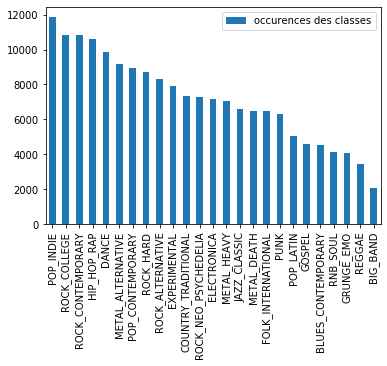

In [4]:
features_list = pd.read_csv(dataset_path_tab[0], header=None, sep = ',')
Y = features_list.iloc[:,-1]
df = pd.DataFrame(Y.value_counts())
ax = df.plot(kind='bar')
ax.legend(["occurences des classes"]);

Cette analyse nous montre que la plupart des classes apparaissent environ 7000 fois. Le dataset n'est toutefois pas balancé puisque le nombre d'occurences des classes peut varier entre 2000 et 12000. C'est une caractéristique du dataset qu'il faudra prendre en compte par la suite.

[168, 26, 16, 96, 20, 10, 124, 420, 60, 420]


Text(0.5, 1.0, 'Number of features per dataset')

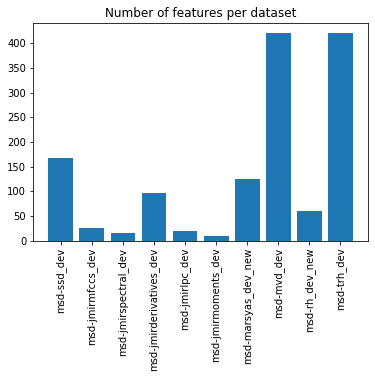

In [5]:
nb_features = []
dataset_path_label = []
for dataset_path in dataset_path_tab:
    features_list = pd.read_csv(dataset_path, header=None, sep = ',', nrows=1)
    nb_features.append(len(features_list.iloc[0,2:-1]))
    dataset_path_label.append(dataset_path.split('/')[2])
    
print(nb_features)
plt.bar(dataset_path_label,nb_features )
plt.xticks(dataset_path_label, rotation='vertical')
plt.title("Number of features per dataset")

Ainsi, on peut remarquer que le nombre de features varie beaucoup en fonction du dataset utilisé. Le nombre de features est particulièrement élevé avec les datasets MVD et TRH. Ces informations sont très utiles pour déterminer s'il est nécessaire de réduire ce nombre avec un algorithme d'analyse en composantes principales (PCA) par exemple.

## Question 2

Comme expliqué précedemment, le modèle MLP est un bon candidat. Toutefois, nous n'avons pas de données sur sa performance avec les ensembles de features du dataset MSD. Nous allons donc créé un modèle MLP est le tester sur tout les ensembles de features disponible pour comparer ses performances. Nous irons plus en détails dans l'ajustement des hyperparamètres par la suite.  
### Validation
Nous utiliserons ici une méthode validation hold-out avec 80% du dataset comme données d'entrainement et 20% en tant que données de tests. Nous utilisons cette méthode de validation pour le choix du partitionnement puisqu'elle à l'avantage d'être plus rapide que la validation croisée.
### Prétraitement
Par ailleurs, on utilise l'option "stratify" de la fonction train_test_split pour que les proportions de chacune des classes soit égale dans le dataset d'entrainement et de celui de test.
On normalise aussi indépendemment chaque features par rapport à la valeur maximale dans le dataset.

#### CLASS_WEIGHTS????

### Configuration de l'environnement
Ici le programme à été exécuté sur une machine ayant les caractéristiques suivantes :

### Partitionnement des données
Pour déterminer au mieux le partitionnement des données, nous testons les performances de chaque modèle choisi avec chaque ensemble de features. Nous irons plus en détails dans l'ajustement des hyperparamètres des modèles par la suite.

In [6]:
from RN_model import RN_model
from tensorflow.keras.callbacks import TensorBoard
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split
import shutil
import time
import numpy as np
from functions import get_data, plot_perf_epochs,plot_perf_delay

Instructions for updating:
non-resource variables are not supported in the long term


In [7]:
dataset_path_tab = []
dataset_path_tab.append("./tagged_feature_sets/msd-ssd_dev/msd-ssd_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-jmirmfccs_dev/msd-jmirmfccs_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-jmirspectral_dev/msd-jmirspectral_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-jmirderivatives_dev/msd-jmirderivatives_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-jmirlpc_dev/msd-jmirlpc_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-jmirmoments_dev/msd-jmirmoments_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-marsyas_dev_new/msd-marsyas_dev_new.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-mvd_dev/msd-mvd_dev.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-rh_dev_new/msd-rh_dev_new.csv")
dataset_path_tab.append("./tagged_feature_sets/msd-trh_dev/msd-trh_dev.csv")

In [8]:
# MLP hyperparamaters
layer_sizes = [500]
epochs = 50
learning_rate = 0.0005
batch_size = 500

dropout = 0.5

In [9]:
training_delay_RN = []
predicting_delay_RN = []
history_obj = []
cpt = 0
best_accuracy_RN = 0
f1_RN = []
acc_RN = []

In [10]:
try:      
    shutil.rmtree('./logs')
except:
    print("nothing to delete")
# Callbacks pour affichage des performances dans tensorboard : callback pour chaque hyperparamètre
tensorboard_callback = []
for i in range(len(dataset_path_tab)):
    tensorboard_callback.append(TensorBoard(log_dir="logs\{}".format(i)))
# Par invité de commande : 
# tensorboard --logdir="./logs" --port 6006

In [12]:
cpt = 0
for path_ in dataset_path_tab:
    # Get data / normalize it / split into train&test
    X, Y,le = get_data(path_)
    X = preprocessing.normalize(X, norm='max',axis = 0)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8,random_state=60, stratify=Y)  # 80% training and 20% test

    # Calcul du nombres de features/classes et taille du dataset
    nb_features = len(X[0])
    nb_classes = max(Y)+1
    train_size = len(X)

    model = RN_model(layer_sizes, dropout, learning_rate, nb_features, nb_classes)
    
    #### Apprentissage                                                                                                                                                               
    start = time.time()                                                                                                                   
    hist_obj = model.fit(X_train[0:train_size], Y_train[0:train_size], batch_size = batch_size, epochs = epochs, validation_data=(X_test, Y_test), callbacks = [tensorboard_callback[cpt]]) 
    end = time.time()
    training_delay_RN.append(end - start)
    
    history_obj.append( list(hist_obj.history.values()))

    #### Prédiction                                                                                                                                                                  
    start = time.time()
    Y_pred_temp = model.predict(X_test)
    end = time.time()
    predicting_delay_RN.append(end - start)

    # Remise en forme de Y_pred
    Y_pred = []
    for i in Y_pred_temp:
        Y_pred.append(np.argmax(i)) 
    
    f1 = metrics.f1_score(Y_test, Y_pred,average='weighted')
    acc = metrics.accuracy_score(Y_test, Y_pred)
    print("acc :", acc,"f1 :", f1)
    
    f1_RN.append(f1)
    acc_RN.append(acc)
    cpt+=1

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 143644 samples, validate on 35911 samples
Epoch 1/50
143644/143644 [==============================] - 5s 38us/sample - loss: 2.7907 - acc: 0.1612 - val_loss: 2.6007 - val_acc: 0.2115
Epoch 2/50
143500/143644 [============================>.] - ETA: 0s - loss: 2.5838 - acc: 0.2124

KeyboardInterrupt: 

In [13]:
# Mise en forme des données pour l'affichage
ho = np.array(history_obj)
ho = ho.transpose(1,2,0)  

# Pour affichage
sub_title = ['loss','acc','val_loss','val_acc']
x_lab = "epochs"
leg = [str(i) for i in range(len(direct_path_tab))]  
titre = "RN : Dataset test"                                                                                                                                         

plot_perf_epochs(ho, leg, titre ,sub_title)
plot_perf_delay(f1_RN,acc_RN,training_delay_RN,predicting_delay_RN,titre)

ValueError: axes don't match array

On remarque que le réseau de neurones performe mieux pour les dataset 0, 3 et 6, c'est à dire avec les ensemble de features : SSD, derivates et maryas.

Pour faire un choix éclairé, on réalise des tests similaires pour les 2 autres modèles choisis.

## Question 3
### Description des modèles et justifications


#### Etudes des hyperparamètres? complète avec tous les tests????????????????????????

## Question 4

### Matrice des expérimentations

### QU'est ce que c'est????????????????????????????????????
Matrices des performances?? accuracy/F1-scores pk "matrice"


### matrices de confusion!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
=> pas lisibles du tout!!!!!!!!

### Matrice des résultats de l'étude des hyperparamètres
### QU'est ce que c'est????????????????????????????????????

### Graphiques

Comme pour le TP précédent, on peut étudier le modèle MLP selon les hyperparamètres suivant : 
  . Nombre de couches cachées
  . Nombre de perceptrons sur la couche cachée
  . Taux d'apprentissage
  . Nombre d'epochs

In [1]:
from RN_hyperparam import *

Instructions for updating:
non-resource variables are not supported in the long term


In [15]:
layer_size_test()

Train on 143644 samples, validate on 35911 samples
Epoch 1/10
143644/143644 [==============================] - 6s 43us/sample - loss: 2.7903 - acc: 0.1616 - val_loss: 2.5994 - val_acc: 0.2125
Epoch 2/10
143644/143644 [==============================] - 5s 34us/sample - loss: 2.5826 - acc: 0.2131 - val_loss: 2.5188 - val_acc: 0.2320
Epoch 3/10
143644/143644 [==============================] - 5s 36us/sample - loss: 2.5220 - acc: 0.2301 - val_loss: 2.4800 - val_acc: 0.2435
Epoch 4/10
143644/143644 [==============================] - 6s 44us/sample - loss: 2.4870 - acc: 0.2416 - val_loss: 2.4487 - val_acc: 0.2520
Epoch 5/10
143644/143644 [==============================] - 6s 40us/sample - loss: 2.4617 - acc: 0.2472 - val_loss: 2.4268 - val_acc: 0.2618
Epoch 6/10
143644/143644 [==============================] - 6s 41us/sample - loss: 2.4431 - acc: 0.2536 - val_loss: 2.4122 - val_acc: 0.2635
Epoch 7/10
143644/143644 [==============================] - 6s 40us/sample - loss: 2.4270 - acc: 0.2591

C:\Users\David\Anaconda3\envs\GTI 770-BIS\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


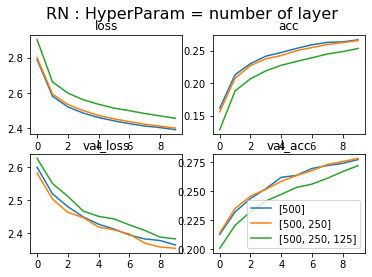

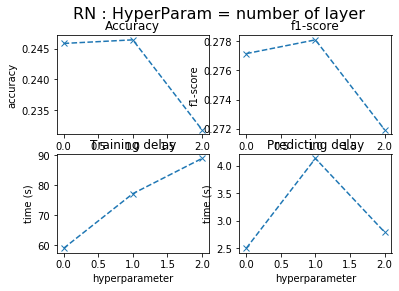

In [16]:
RN_plot_test()

In [2]:
perceptrons_number_test()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 143644 samples, validate on 35911 samples
Epoch 1/50
143644/143644 [==============================] - 3s 23us/sample - loss: 2.9212 - acc: 0.1315 - val_loss: 2.6920 - val_acc: 0.1902
Epoch 2/50
143644/143644 [==============================] - 3s 18us/sample - loss: 2.7019 - acc: 0.1787 - val_loss: 2.5970 - val_acc: 0.2122
Epoch 3/50
143644/143644 [==============================] - 3s 19us/sample - loss: 2.6350 - acc: 0.1968 - val_loss: 2.5521 - val_acc: 0.2236
Epoch 4/50
143644/143644 [==============================] - 3s 21us/sample - loss: 2.5961 - acc: 0.2099 - val_loss: 2.5204 - val_acc: 0.2317
Epoch 5/50
143644/143644 [==============================] - 3s 18us/sample - loss: 2.5690 - acc: 0.2189 - val_loss: 2.5015 - val_acc: 0.2356
Epoch 6/50
143644/143644 [==============================] - 4s 28us/sample - loss: 2.5504 - acc: 0.2247 - val_loss: 2.4819 - val_acc: 0.2408
Epoch 7/50
143644/1436

143644/143644 [==============================] - 7s 46us/sample - loss: 2.4903 - acc: 0.2403 - val_loss: 2.4510 - val_acc: 0.2501 ac
Epoch 5/50
143644/143644 [==============================] - 6s 43us/sample - loss: 2.4651 - acc: 0.2469 - val_loss: 2.4322 - val_acc: 0.2567s:
Epoch 6/50
143644/143644 [==============================] - 6s 44us/sample - loss: 2.4446 - acc: 0.2533 - val_loss: 2.4131 - val_acc: 0.2644
Epoch 7/50
143644/143644 [==============================] - 6s 45us/sample - loss: 2.4291 - acc: 0.2577 - val_loss: 2.4033 - val_acc: 0.2666
Epoch 8/50
143644/143644 [==============================] - 6s 43us/sample - loss: 2.4135 - acc: 0.2634 - val_loss: 2.3854 - val_acc: 0.2720c: 0.26
Epoch 9/50
143644/143644 [==============================] - 6s 45us/sample - loss: 2.4021 - acc: 0.2656 - val_loss: 2.3780 - val_acc: 0.2738
Epoch 10/50
143644/143644 [==============================] - 6s 43us/sample - loss: 2.3944 - acc: 0.2671 - val_loss: 2.3686 - val_acc: 0.2748
Epoch 11/50

143644/143644 [==============================] - 10s 72us/sample - loss: 2.3686 - acc: 0.2746 - val_loss: 2.3557 - val_acc: 0.2772
Epoch 11/50
143644/143644 [==============================] - 10s 71us/sample - loss: 2.3612 - acc: 0.2756 - val_loss: 2.3433 - val_acc: 0.2805
Epoch 12/50
143644/143644 [==============================] - 10s 70us/sample - loss: 2.3510 - acc: 0.2789 - val_loss: 2.3444 - val_acc: 0.2801
Epoch 13/50
143644/143644 [==============================] - 10s 72us/sample - loss: 2.3457 - acc: 0.2808 - val_loss: 2.3425 - val_acc: 0.2809
Epoch 14/50
143644/143644 [==============================] - 11s 73us/sample - loss: 2.3386 - acc: 0.2826 - val_loss: 2.3298 - val_acc: 0.2863
Epoch 15/50
143644/143644 [==============================] - 10s 71us/sample - loss: 2.3328 - acc: 0.2838 - val_loss: 2.3301 - val_acc: 0.2865
Epoch 16/50
143644/143644 [==============================] - 11s 74us/sample - loss: 2.3258 - acc: 0.2856 - val_loss: 2.3155 - val_acc: 0.2902
Epoch 17/50

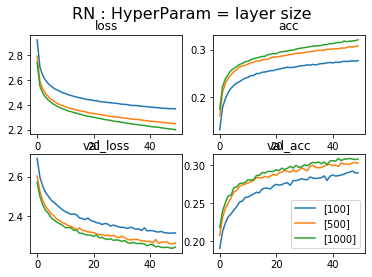

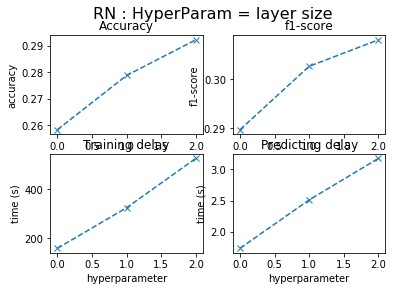

In [3]:
RN_plot_test()

In [ ]:
learning_rate_test()

In [ ]:
RN_plot_test()

In [ ]:
epochs_number_test()

In [ ]:
RN_plot_test()

### Discussion

## Question 5
### Présentation de la conception


A FAIRE : SAUVEGARDE DES MODELES DANS DES PICKLE
faire diagramme

## Question 6
### Hyperparamètres des modèles choisis dans la conception


### Matrice des résultats

### Discussion

comparaison entre les modèles prit independemment et les modèles combinés

## Question 7 
### Formulation des recommandations

## Conclusion